In [21]:
# Import packages
# from preprocessing.filtering import Preprocess
# from preprocessing.fiducials import FpCollection
# from preprocessing import PPG

# from preprocessing import Fiducials, Biomarkers
# import pyPPG.biomarkers as BM

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# from pathlib import Path
# from dotmap import DotMap
# import numpy as np
# import pandas as pd
# import scipy.io
# import random
# import os
# import h5py



In [22]:
# Import packages
from utils.dataloaders import Crops
from utils import random_state
import random

random_state(36)

In [23]:
# dataset
crops_data = Crops()
crops_data.split(test_size=0.15)

# test_set = CropsDataset(crops_data.test, mode=mode, stratify=False)
# val_set = CropsDataset(crops_data.val, mode=mode, stratify=True)
# train_set = CropsDataset(crops_data.train, mode=mode, stratify=True)

loading N_crops.h5...
loading V_crops.h5...
loading S_crops.h5...


In [24]:
# Parameters
stratify = True

# Stratify
V = []
S = []
N = []
for x, y in crops_data.train:
    if y == "V" :
        V.append(x)
    elif y == "S":
        S.append(x)
    else:
        N.append(x)

n_smallest_class = min(len(V), len(S))
dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}

# Stratify the dataset
if stratify:
    random.seed(36)
    for label, crops in dataset.items():
        if len(crops) > n_smallest_class:
            random.shuffle(crops)
            if label == 'N':
                dataset[label] = crops[0:2*n_smallest_class]

            elif label in ['V', 'S']:
                dataset[label] = crops[0:n_smallest_class]

for label, crops in dataset.items():
    print(f'{label}: {len(crops)}')

print(f'Total number of crops for training: {sum([len(crops) for crops in dataset.values()])} / {4*n_smallest_class}')

N: 11192
V: 5596
S: 5596
Total number of crops for training: 22384 / 22384


In [25]:
# Parameters
stratify = True

data = {}
for split_name, split_data in zip(["train", "val", "test"], [crops_data.train, crops_data.val, crops_data.test]):

    # Stratify
    V = []
    S = []
    N = []
    for crop, label in split_data:
        if label == "V" :
            V.append(crop)
        elif label == "S":
            S.append(crop)
        else:
            N.append(crop)

    n_smallest_class = min(len(V), len(S))
    dataset = {label: crops for label, crops in zip(['N', 'V', 'S'], [N, V, S])}
    
    # Stratify the dataset
    if split_name in ["train", "val"]:
        if stratify:
            random.seed(36)
            for label, crops in dataset.items():
                if len(crops) > n_smallest_class:
                    random.shuffle(crops)
                    if label == 'N':
                        dataset[label] = crops[0:2*n_smallest_class]

                    elif label in ['V', 'S']:
                        dataset[label] = crops[0:n_smallest_class]

    data[split_name] = dataset

    print(f'{split_name} dataset:')
    for label, crops in dataset.items():
        print(f'{label}: {len(crops)}')
    print('-'*20)



print(f'Total number of crops for training: {sum([len(crops) for crops in data["train"].values()])}')

train dataset:
N: 11192
V: 5596
S: 5596
--------------------
val dataset:
N: 2398
V: 1199
S: 1199
--------------------
test dataset:
N: 34056
V: 1199
S: 1454
--------------------
Total number of crops for training: 22384


In [26]:
len(data['train']['N'])

data_train_N = data['train']['N']
data_train_V = data['train']['V']
data_train_S = data['train']['S']


In [27]:
import matplotlib.pyplot as plt
import numpy as np

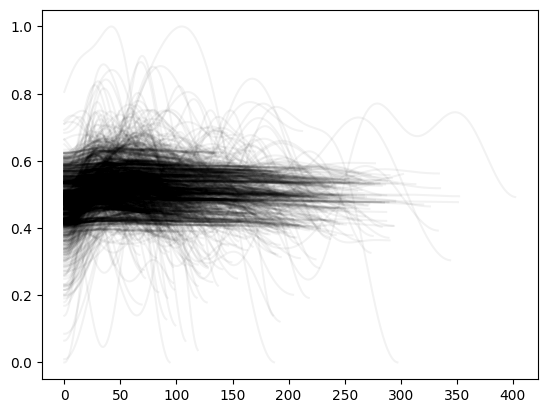

In [28]:
for i in range(2000):
    plt.plot(data_train_N[i], 'k', alpha=0.05)

plt.show()

In [9]:
max_len = np.max([len(crop) for crop in data_train_N])
n = len(data_train_N)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

avg = np.zeros(max_len)

for crop, maxim in zip(data_train_N, max_ampl):
    n_crop = len(crop)
    avg[:n_crop] += crop/n/maxim

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# a = np.array(data_train_S)
max_ampl = [np.max(np.abs(crop)) for crop in data_train_N]

print(max_ampl)

for i in range(2000):
    if max_ampl[i] < 80:
        plt.plot(data_train_N[i]/max_ampl[i], 'k', alpha=0.05)
    else:
        plt.plot(data_train_N[i]/max_ampl[i], 'b', alpha=0.5)

plt.plot(avg, 'r')

plt.show()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
plt.hist(max_ampl, bins=5000)
plt.show()

NameError: name 'max_ampl' is not defined

In [ ]:
np.sort(max_ampl)[-50:]

NameError: name 'max_ampl' is not defined

EXTRACTING FEATURES FROM CROPS AND WRITING TO CSV

In [29]:
import numpy as np

from scipy import stats


print('Number of N crops: ',len(data_train_N))
test_crop = data_train_N[11]
print('Length of test crop: ', len(test_crop))


Number of N crops:  11192
Length of test crop:  90


In [30]:
import pandas as pd

def find_nearest(array, value): #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array, used for one of features
    array = np.asarray(array)
    if len(array) == 0:
        idx = 0
    else:
        idx = (np.abs(array - value)).argmin()
    return idx

def get_pulse_width(crop):  #need to verify if this done correctly...

    half_peak = max(crop)/2
    idx_peak = np.argmax(crop[1:])
    idx_t1 = find_nearest(crop[:idx_peak], half_peak) #number of timesteps for amplitude to get to half value of peak before peak
    idx_t1 = len(crop[:idx_peak]) -idx_t1 #time from that point to peak
    idx_t2 = find_nearest(crop[idx_peak:], half_peak) #number of timesteps for amplitude to get to half value of peak after peak

    return idx_t2+idx_t1 #time between half maximum values
    
def drop_empty_crops(crops):

    out = [crop for crop in crops if len(crop) > 4]
    print("Number of crops eliminated: ", len(crops)-len(out))
    return out


def crops2features(crops):

    list_of_features = ['mean', 'median', 'std', 'var', 'skew', 'kurt','auc','peak_amplitude','pulse_width']

    ind = 0
    df = pd.DataFrame(columns = list_of_features)
    for crop in crops:

        #First 6 features taken from Lab 1, rest inspired by ChatGPT
        values = [np.mean(crop),
                  np.median(crop),
                  np.std(crop),
                  stats.tvar(crop),
                  stats.skew(crop),
                  stats.kurtosis(crop),

                    sum(np.array(crop)-min(crop)), #not sure if sound, since min could also be before or after crop...
                    max(crop)-min(crop), #idem
                    get_pulse_width(crop)
                  ]

        df2 = pd.DataFrame(dict(zip(list_of_features,
                                    values)), index = [ind])
        df = pd.concat([df,df2])
        ind += 1

    return df


In [31]:
data_train_N = drop_empty_crops(data_train_N)
data_train_S = drop_empty_crops(data_train_S)
data_train_V = drop_empty_crops(data_train_V)

Number of crops eliminated:  7
Number of crops eliminated:  3
Number of crops eliminated:  0


In [32]:
N_features = crops2features(data_train_N)

In [33]:
S_features = crops2features(data_train_S)
V_features = crops2features(data_train_V)

In [34]:
N_features.head()

,mean,median,std,var,skew,kurt,auc,peak_amplitude,pulse_width
0,0.555991,0.555785,0.068674,0.004738,-0.073723,-1.350694,25.856566,0.220030,115
1,0.578392,0.576914,0.012017,0.000145,0.157563,-0.995838,3.313621,0.039851,171
2,0.495744,0.494071,0.023315,0.000553,0.061473,-1.470351,1.957976,0.068387,56
3,0.478668,0.477920,0.014787,0.000221,-0.096847,-1.189768,2.074852,0.047082,80
4,0.530839,0.514678,0.053444,0.002885,0.674311,-0.886330,6.471702,0.167911,100


In [35]:
from sklearn.model_selection import train_test_split

N_features = N_features.dropna()
S_features = S_features.dropna()
V_features = V_features.dropna()


labels = [1 for i in range(len(N_features))]+[0 for i in range(len(S_features))]+[0 for i in range(len(V_features))]
dataset = pd.concat([N_features,S_features,V_features])


print((len(labels)))
print(len(dataset))



22374
22374


In [36]:
#Writing to CSV

N_features.to_csv('temp_dir/N_features_ML.csv')
V_features.to_csv('temp_dir/V_features_ML.csv')
S_features.to_csv('temp_dir/S_features_ML.csv')


In [37]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat([N_features,S_features,V_features]),labels, test_size=0.3,random_state=109) # 70% training and 30% test


Accuracy: 0.7851929092805006


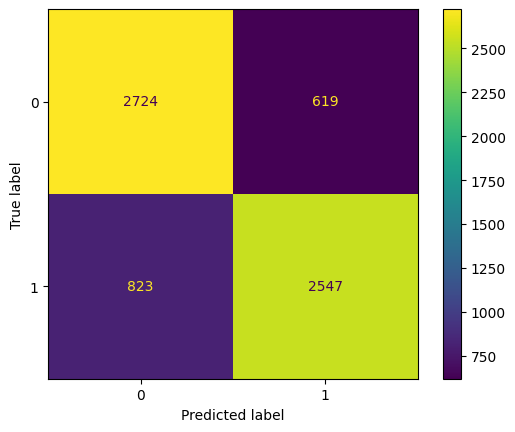

In [38]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


TO DO: Exploit full training data and using the already made test set (that I ignored for now)